In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`source activate bailfund`

To fetch dockets in backgrounded batches:

```bash
./spawn_batches.sh 42 48 1000 2013 ./batches.sh
```

To fetch summaries in backgrounded batches:
```bash
./spawn_batches.sh 42 48 1000 2013 ./batches_summaries.sh
```

http://www.legis.state.pa.us/WU01/LI/LI/CT/htm/18/18.htm

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2777615


In [2]:
import pandas as pd
import re
import os
import subprocess

In [3]:
cd summaries/

/Users/cchivers/proj/bailfund/summaries


In [4]:
# n_files = len(bfanal)
# for i,f in enumerate(bfanal):
#     if (i % int(n_files/10)) == 0:
#         print("{0:.0%} complete".format(i/n_files))
#     bashCommand = 'cp '+ f + ' ../compressed_summaries/'
#     process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
#     output, error = process.communicate()

In [180]:
fnames = [f for f in os.listdir('./') if f.endswith('.pdf')]
txt_names = [f for f in os.listdir('./') if f.endswith('.txt')]

f_roots = [f[:-4] for f in fnames]
t_roots = [f[:-4] for f in txt_names]
f_roots = list(set(f_roots) - set(t_roots))
fnames = [f+'.pdf' for f in f_roots]
fnames = [f for f in fnames if os.stat(f).st_size>0]
len(fnames)

29

In [181]:
n_files = len(fnames)
for i,f in enumerate(fnames):
    if (i % int(n_files/10)) == 0:
        print("{0:.0%} complete".format(i/n_files))
    bashCommand = 'pdftotext '+ f
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()

0% complete
7% complete
14% complete
21% complete
28% complete
34% complete
41% complete
48% complete
55% complete
62% complete
69% complete
76% complete
83% complete
90% complete
97% complete


In [182]:
def get_colonic(lines, pre_colonic):
    ao = [l for l in lines if pre_colonic in l]
    key = pre_colonic[:-1]
    if len(ao) == 0:
        return {key:''}
    res = ao[0].split(': ')
    if len(res) > 1:
        res = res[-1].rstrip()
    else:
        res = ''
    return {key: res}

colonics = ['Sex:','Eyes:','Hair:','Race:','DOB:','Printed:']
colonics_this_dn = ['Proc Status:','DC No:','Disp Date:','Disp Judge:','Arrest Dt:','Def Atty:']

def get_defendant(lines):
    idx = [i for i,l in enumerate(lines) if 'CASE INFORMATION' in l]
    return {'Defendant': lines[idx[0]-1].rstrip()}
    
def get_all_colonics(lines,fname):
    res = {}
    #docket_number = fname.split('.')[0] 
    #first_line_with_docket_numeber = min([i for i,l in enumerate(lines) if docket_number in l])
    #lines_after_dn = [l for i,l in enumerate(lines) if i > first_line_with_docket_numeber]
    lines_after_dn = lines
    for colonic in colonics:
        res.update(get_colonic(lines_after_dn, colonic))
    return res

def get_all_colonics_this_docket(lines,fname):
    res = {}
    docket_number = fname.split('.')[0] 
    first_line_with_docket_numeber = min([i for i,l in enumerate(lines) if docket_number in l])
    lines_after_dn = [l for i,l in enumerate(lines) if i >= first_line_with_docket_numeber]
    for colonic in colonics_this_dn:
        res.update(get_colonic(lines_after_dn, colonic))
    return res

def get_all_charges(lines):
    all_charges = list(set([re.sub('[ (\n)]','',l) for i,l in enumerate(lines) if ('§' in l)]))
    return {'Charges': all_charges}

def get_bail_amounts(lines):
    idx = [i for i,l in enumerate(lines) if ('BAIL INFORMATION' in l) or ('CHARGES' in l)]
    if len(idx) < 2:
        return {'Bail': []}
    start_idx, end_idx = idx[0], idx[-1]
    amounts = [l.rstrip() for l in lines[start_idx:end_idx] if '$' in l]
    return {'Bail': amounts}

def get_magistrate(lines):
    idx = [i for i,l in enumerate(lines) if ('Arraignment Court Magistrate' in l)]
    res = ''
    if len(idx) > 0:
        res = lines[idx[0]+1].rstrip()
    return {'Arraignment Court Magistrate': res}

def get_arraignment_date(lines):
    prelim = False
    res = {'Arraignment Date': ''}
    for i,l in enumerate(lines):
        if prelim and l.rstrip() == 'Arraignment':
            idx = i
            res = {'Arraignment Date': lines[idx+2].rstrip() + ' ' + lines[idx+4].rstrip()}
            break
        prelim = False
        if l.rstrip() == 'Preliminary':
            prelim = True
    return res

def get_docket_number(lines):
    docket_number = fname.split('.')[0]
    first_line_with_docket_numeber = ([l for i,l in enumerate(lines) if docket_number in l])
    return {'Docket Number': first_line_with_docket_numeber[0].rstrip()}

fnames = [f for f in os.listdir('./') if f.endswith('.txt')]
n_files = len(fnames)
res_list = []
print('Extractinng {} dockets'.format(n_files))
for i,fname in enumerate(fnames):
    if (i % int(n_files/10)) == 0:
        print("{0:.0%} complete".format(i/n_files))
    with open(fname,'r') as f:
        lines = f.readlines()
    res = {'fname': fname}
    res.update(get_docket_number(lines))
#     res.update(get_all_charges(lines))
    res.update(get_all_colonics(lines, fname))
#     res.update(get_all_colonics_this_docket(lines, fname))
#     res.update(get_defendant(lines))
#     res.update(get_bail_amounts(lines))
#     res.update(get_magistrate(lines))
#     res.update(get_arraignment_date(lines))
    res_list.append(res)

res_df = pd.DataFrame(res_list)

Extractinng 21495 dockets
0% complete
10% complete
20% complete
30% complete
40% complete
50% complete
60% complete
70% complete
80% complete
90% complete
100% complete


In [183]:
res_df.head()

,DOB,Docket Number,Eyes,Hair,Printed,Race,Sex,fname
0,12/19/1992,MC-51-CR-0000001-2018,Brown,Brown,8/29/2018 8:00 PM,Black,Female,0000001-2018.txt
1,10/07/1991,MC-51-CR-0000002-2018,Hazel,Brown,8/29/2018 8:00 PM,Black,Female,0000002-2018.txt
2,08/17/1972,MC-51-CR-0000003-2018,Black,Black,8/29/2018 8:00 PM,Black,Male,0000003-2018.txt
3,10/10/1987,MC-51-CR-0000005-2018,Brown,Black,8/29/2018 8:00 PM,Black,Male,0000005-2018.txt
4,01/27/1995,MC-51-CR-0000006-2018,Brown,Black,8/29/2018 8:00 PM,Black,Male,0000006-2018.txt


In [184]:
res_df.shape

(21495, 8)

In [185]:
res_df['fname'].head()

0    0000001-2018.txt
1    0000002-2018.txt
2    0000003-2018.txt
3    0000005-2018.txt
4    0000006-2018.txt
Name: fname, dtype: object

In [186]:
res_df[res_df['fname'] == '0000099-2018.txt']

,DOB,Docket Number,Eyes,Hair,Printed,Race,Sex,fname
89,06/03/1989,MC-51-CR-0000099-2018,Green,Brown,8/29/2018 8:37 PM,White,Male,0000099-2018.txt


In [216]:
dockets = pd.read_csv('../2018_docket_extracts.csv')
dockets.shape

(57950, 18)

In [217]:
dockets = dockets.merge(res_df,how='left',on='Docket Number')
dockets.shape

(57950, 25)

In [250]:
#dockets.head()

In [219]:
dockets['Sex'].value_counts()/dockets['Sex'].value_counts().sum()

Male                  0.821764
Female                0.178189
Unreported/Unknown    0.000046
Name: Sex, dtype: float64

In [220]:
dockets['Race'].value_counts()/dockets['Race'].value_counts().sum()

Black                             0.583237
White                             0.401250
Asian/Pacific Islander            0.010697
Unknown/Unreported                0.003010
                                  0.000926
Native American/Alaskan Native    0.000741
Bi-Racial                         0.000093
Asian                             0.000046
Name: Race, dtype: float64

In [221]:
dockets['Arraignment Court Magistrate'].value_counts()/dockets['Arraignment Court Magistrate'].value_counts().sum()

Series([], Name: Arraignment Court Magistrate, dtype: float64)

In [222]:
dockets['Bail'].head()

0                                   ['$0.00']
1                                   ['$0.00']
2                                   ['$0.00']
3    ['$5,000.00', '$5,000.00', '$25,000.00']
4                             ['$100,000.00']
Name: Bail, dtype: object

In [223]:
import re
import ast
def safe_int(x):
    x = re.sub('[^0-9\.]','',x)
    try:
        return float(x)
    except:
        print(x)
        return 0.0

def get_max_bail(x):
    x = ast.literal_eval(x)
    if len(x) == 0:
        return 0
    bail_int = np.array([safe_int(l) for l in x]).max()
    return bail_int

dockets['Bail Max'] = dockets['Bail'].apply(get_max_bail)

..100000.00
1012000.0010.5112018.
..100000.0010
..25000.0010
..50000.0010
..15000.0010
..30000.0010.
300.00.
5000.005300.0010.
12330..
3700.00.
.10001..
1500.00.
1500.00.
300.005000.005300.0010
..2500010
1500010..
1000...
300.00.
.1500.00
1000.00.
5000.00.
1000.0010.
235.20..22117906
.25000.
600..3934.
.1013..12000
...1000.00
.30090.
500.00.
175.00.
.500.00..175.00.
..1000.00
..600.00


In [224]:
dockets['Bail Max'].head()

0         0.0
1         0.0
2         0.0
3     25000.0
4    100000.0
Name: Bail Max, dtype: float64

In [225]:
dockets['Date Filed'] = pd.to_datetime(dockets['Date Filed'])
#res_df['Arraignment Date'] = pd.to_datetime(res_df['Arraignment Date'])
#res_df['Initiation Date'] = pd.to_datetime(res_df['Initiation Date'])
#res_df.shape

In [226]:
dockets['Docket ID'] = dockets['Docket Number'].apply(lambda x: x.split('-')[3])
dockets['Docket Year'] = dockets['Docket Number'].apply(lambda x: x.split('-')[4])

In [227]:
# tmp = res_df[res_df['Docket Year'] == '2016']
# tmp['Docket ID'].astype(int).sort_values().head(10)

0022252 2018
2018-01-01 00:00:00 2018-08-29 00:00:00
0039224 2017
2017-01-01 00:00:00 2017-12-31 00:00:00


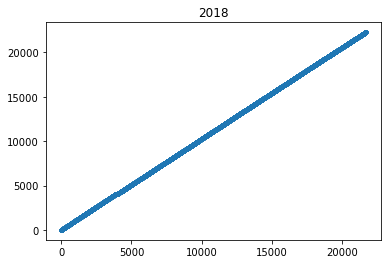

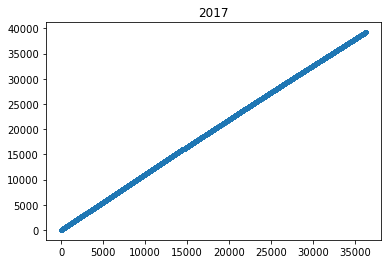

In [228]:
for year in dockets['Docket Year'].unique():
    tmp = dockets[dockets['Docket Year'] == year]
    print(tmp['Docket ID'].max(),year)
    print(tmp['Date Filed'][tmp['Docket ID'].argmin()], tmp['Date Filed'][tmp['Docket ID'].argmax()])
    fig, ax = plt.subplots(1,1)
    ax.plot(tmp['Docket ID'].astype(int).sort_values().values,'.')
    ax.set_title(year)

In [229]:
dockets2 = dockets.sort_values(['Defendant',
                              'Date Filed']).drop_duplicates(['Defendant',
                                                                    'Date Filed'],keep='last')

In [230]:
dockets2.shape

(52362, 26)

In [231]:
dockets2['count'] = 1
ts = dockets2.set_index('Date Filed').resample('1d').sum().fillna(0)
ts.head()

,Arraignment Court Magistrate,Bail Max,count
Date Filed,,,
2017-01-01,0.0,753700.0,54
2017-01-02,0.0,1664700.0,51
2017-01-03,0.0,766535.2,50
2017-01-04,0.0,2086100.0,85
2017-01-05,0.0,3985650.0,83


In [232]:
ts.index.min(), ts.index.max(), 

(Timestamp('2017-01-01 00:00:00', freq='D'),
 Timestamp('2018-08-29 00:00:00', freq='D'))

In [233]:
ts['count'].min(), ts['count'].max()

(28, 176)

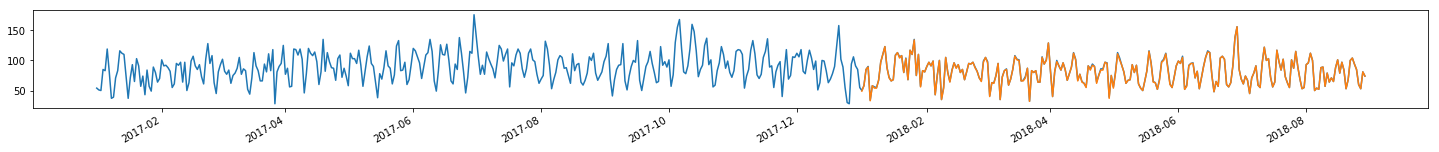

In [234]:
ts = ts[ts.index > datetime.datetime(2012,1,1)]
fig, ax = plt.subplots(1,1,figsize=(25,2))
ax.plot(ts['count'])
fig.autofmt_xdate()

ts = dockets2[pd.notnull(dockets2['Race'])].set_index('Date Filed').resample('1d').sum().fillna(0)
ts = ts[ts.index > datetime.datetime(2012,1,1)]
ax.plot(ts['count'])
fig.autofmt_xdate()

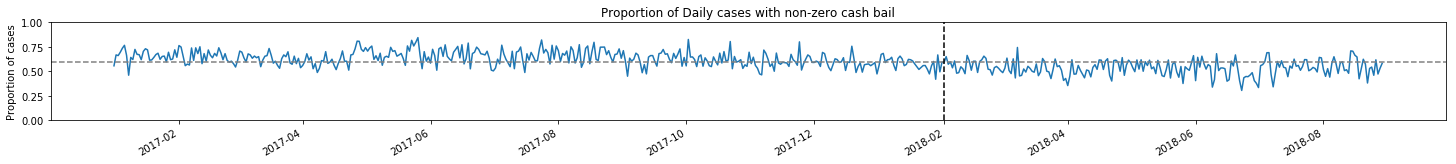

In [247]:
dockets2['Non-Zero Bail'] = dockets2['Bail Max'] > 0
ts = dockets2.set_index('Date Filed').resample('1d').mean().fillna(0)
ts = ts[ts.index > datetime.datetime(2012,1,1)]

fig, ax = plt.subplots(1,1,figsize=(25,2))
ax.plot(ts['Non-Zero Bail'])
ax.set_ylim(0,1)
ax.axhline(ts['Non-Zero Bail'].mean(),ls='--',color='grey')
ax.set_ylabel('Proportion of cases')
ax.set_title('Proportion of Daily cases with non-zero cash bail')
ax.axvline(datetime.datetime(2018,2,1),ls='--',color='black')
fig.autofmt_xdate()

In [241]:
dockets2[dockets2['Date Filed'] < datetime.datetime(2018,2,1)]['Non-Zero Bail'].mean()

0.63165032633571605

In [242]:
dockets2[dockets2['Date Filed'] > datetime.datetime(2018,2,1)]['Non-Zero Bail'].mean()

0.52799336453581369

In [243]:
0.63165 - 0.52799

0.10366000000000009

In [244]:
0.10 * dockets2[dockets2['Date Filed'] > datetime.datetime(2018,2,1)].shape[0]

1687.9

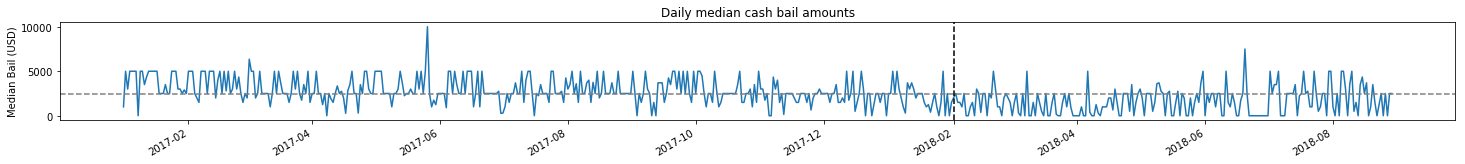

In [249]:
ts = dockets2.set_index('Date Filed').resample('1d').median().fillna(0)
ts = ts[ts.index > datetime.datetime(2012,1,1)]

fig, ax = plt.subplots(1,1,figsize=(25,2))
ax.plot(ts['Bail Max'])
ax.axhline(ts['Bail Max'].mean(),ls='--',color='grey')
ax.set_ylabel('Median Bail (USD)')
ax.set_title('Daily median cash bail amounts')
ax.axvline(datetime.datetime(2018,2,1),ls='--',color='black')
fig.autofmt_xdate()

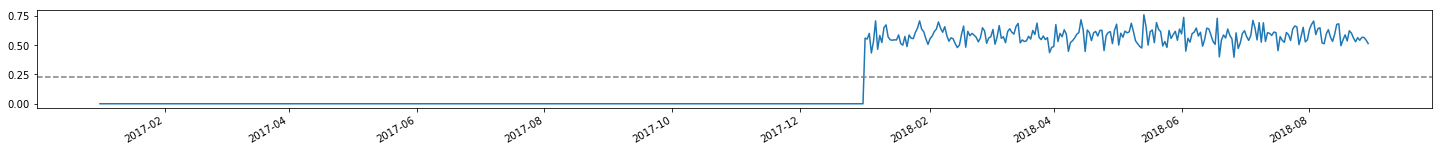

In [238]:
dockets2['IS BLACK'] = dockets2['Race'] == 'Black'
ts = dockets2.set_index('Date Filed').resample('1d').mean().fillna(0)
ts = ts[ts.index > datetime.datetime(2012,1,1)]

fig, ax = plt.subplots(1,1,figsize=(25,2))
ax.plot(ts['IS BLACK'])
ax.axhline(ts['IS BLACK'].mean(),ls='--',color='grey')
fig.autofmt_xdate()

In [252]:
dockets['Arresting Officer'].apply(lambda x: x.upper()).value_counts()

AFFIANT                      4063
MCCAULEY, JOSEPH J.           954
WATSON, DUANE A.              688
CEREBE, KATHALEEN V.          602
BANNING, PATRICK              569
PROSS, ERIK D.                554
KILLMAN, ROBERT A.            500
SCHWEIZER, SCOTT              402
RIVERA, ERIC                  342
ELLIS, JOHN J.                330
RIVERA, RICHARD               329
FLYNN, RYAN J.                325
ARMSTEAD, TYRIC D.            319
REILLY, JAMES M.              270
COTTMAN, AARON B.             259
BALMER, JAMES M.              250
LOMBARDI, MICHAEL A.          242
CESPEDES, BENJAMIN R.         231
HARRON, CHARLES M. III        199
FITZGERALD, THOMAS            197
OUTTERBRIDGE, BRYAN           177
LOGAN, GERALD D. III          165
TORIBIO, OSWALDO A.           164
RAMOS, ROLLIE D.              160
RODRIGUEZ, VICTOR             156
THOMPSON, EDWARD L.           151
HARRIS, STEVEN                145
SCHAFFLING, THOMAS A.         143
YUN, ANDY                     134
CURRAN, JAMES 

In [254]:
all_bail = []
first_bail = []
for b in dockets['Bail'].values:
    bb = ast.literal_eval(b)
    all_bail.extend(bb)
    if len(bb)>0:
        first_bail.append(bb[0])
pd.Series(all_bail).value_counts()

$0.00                                                                                                           25796
$5,000.00                                                                                                       10029
$2,500.00                                                                                                        5727
$10,000.00                                                                                                       5250
$25,000.00                                                                                                       3238
$50,000.00                                                                                                       2985
$1,500.00                                                                                                        2679
$1,000.00                                                                                                        2254
$15,000.00                                              

In [255]:
import numpy as np

In [256]:
first_bail_series = pd.Series([float(re.sub('[\$,]','',b)) for b in first_bail])
first_bail_series.value_counts()

0.0          23844
5000.0        6592
10000.0       3595
2500.0        3556
25000.0       2171
50000.0       1964
1500.0        1858
1000.0        1437
100000.0      1179
15000.0       1174
150000.0       986
7500.0         827
20000.0        822
250000.0       805
75000.0        704
3000.0         615
12000.0        530
200000.0       523
6700.0         495
500000.0       486
3700.0         477
3500.0         425
500.0          270
35000.0        250
2000.0         215
350000.0       212
300000.0       197
30000.0        189
1000000.0      172
750000.0       151
             ...  
13000.0          3
275000.0         3
22000.0          3
140000.0         2
120000.0         2
6500.0           2
55000.0          2
950000.0         2
37500.0          2
750.0            2
65000.0          2
28000.0          2
185000.0         1
180000.0         1
1250000.0        1
37000.0          1
24000.0          1
1800.0           1
100.0            1
550000.0         1
875000.0         1
375000.0    

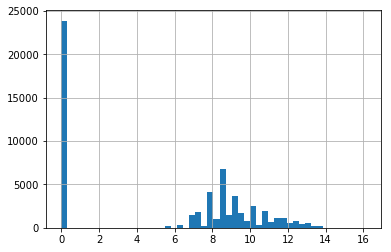

In [257]:
np.log(first_bail_series + 1).hist(bins=50)

In [258]:
first_bail_series.max()

10000000.0